In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, norm
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/processed/loan_default_cleaned.csv')

# ---- DEFINE A/B GROUPS ----
# Control   = No Co-Signer
# Treatment = Has Co-Signer
control = df[df['HasCoSigner'] == 'No']['Default']
treatment = df[df['HasCoSigner'] == 'Yes']['Default']

print("A/B Test: Impact of Co-Signer on Loan Default")
print("="*50)
print(f"Control (No Co-Signer)   — N: {len(control):,}, Default Rate: {control.mean():.4f} ({control.mean()*100:.2f}%)")
print(f"Treatment (Has Co-Signer) — N: {len(treatment):,}, Default Rate: {treatment.mean():.4f} ({treatment.mean()*100:.2f}%)")
print(f"\nAbsolute Difference: {(control.mean() - treatment.mean())*100:.2f}%")
print(f"Relative Lift: {((control.mean() - treatment.mean())/control.mean())*100:.2f}%")

# ---- CHI-SQUARE TEST ----
contingency_table = pd.crosstab(df['HasCoSigner'], df['Default'])
print("\nContingency Table:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-Square Test:")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-Value: {p_value:.6f}")
print(f"Degrees of Freedom: {dof}")
print(f"Result: {'SIGNIFICANT ' if p_value < 0.05 else 'NOT SIGNIFICANT ❌'}")

# ---- Z-TEST FOR PROPORTIONS ----
n_control = len(control)
n_treatment = len(treatment)
p_control = control.mean()
p_treatment = treatment.mean()
p_pool = (control.sum() + treatment.sum()) / (n_control + n_treatment)

z_stat = (p_control - p_treatment) / np.sqrt(p_pool * (1 - p_pool) * (1/n_control + 1/n_treatment))
p_value_z = 2 * (1 - norm.cdf(abs(z_stat)))

print(f"\nZ-Test for Proportions:")
print(f"Z-Statistic: {z_stat:.4f}")
print(f"P-Value: {p_value_z:.6f}")

# ---- CONFIDENCE INTERVAL ----
se = np.sqrt(p_control*(1-p_control)/n_control + p_treatment*(1-p_treatment)/n_treatment)
diff = p_control - p_treatment
ci_lower = diff - 1.96 * se
ci_upper = diff + 1.96 * se
print(f"\n95% Confidence Interval for difference:")
print(f"[{ci_lower*100:.3f}%, {ci_upper*100:.3f}%]")

# ---- EFFECT SIZE (Cohen's h) ----
cohens_h = 2 * np.arcsin(np.sqrt(p_control)) - 2 * np.arcsin(np.sqrt(p_treatment))
print(f"\nEffect Size (Cohen's h): {cohens_h:.4f}")
print(f"Interpretation: {'Small' if abs(cohens_h) < 0.2 else 'Medium' if abs(cohens_h) < 0.5 else 'Large'}")

A/B Test: Impact of Co-Signer on Loan Default
Control (No Co-Signer)   — N: 127,646, Default Rate: 0.1287 (12.87%)
Treatment (Has Co-Signer) — N: 127,701, Default Rate: 0.1036 (10.36%)

Absolute Difference: 2.51%
Relative Lift: 19.48%

Contingency Table:
Default           0      1
HasCoSigner               
No           111223  16423
Yes          114471  13230

Chi-Square Test:
Chi2 Statistic: 390.3050
P-Value: 0.000000
Degrees of Freedom: 1
Result: SIGNIFICANT 

Z-Test for Proportions:
Z-Statistic: 19.7623
P-Value: 0.000000

95% Confidence Interval for difference:
[2.258%, 2.754%]

Effect Size (Cohen's h): 0.0783
Interpretation: Small


Power Analysis
Achieved Power: 1.0000
Interpretation: Sufficient (>0.8) 

Minimum sample size needed per group: 2,558
Actual sample size per group: 127,646
We have 49.9x the required sample size


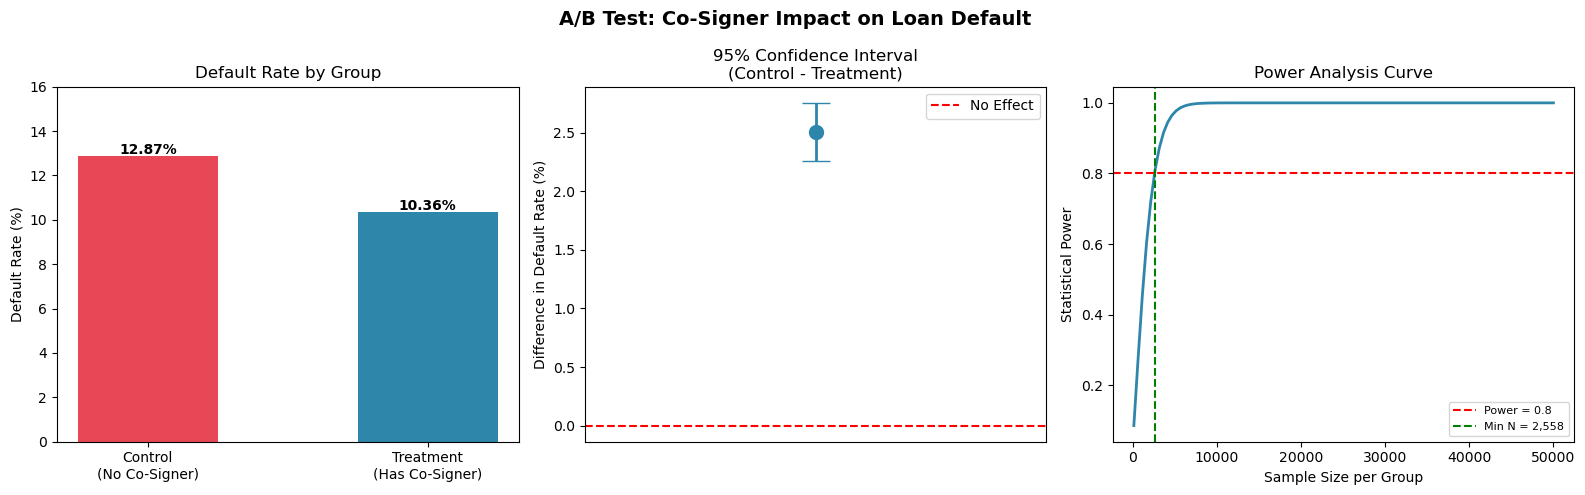


A/B test visualizations saved.


In [4]:
# ---- POWER ANALYSIS ----
from statsmodels.stats.power import NormalIndPower

print("Power Analysis")
print("="*50)

# What power did we actually achieve?
effect_size = cohens_h
n_per_group = min(n_control, n_treatment)
power_analysis = NormalIndPower()
achieved_power = power_analysis.solve_power(
    effect_size=effect_size,
    nobs1=n_per_group,
    alpha=0.05,
    alternative='two-sided'
)
print(f"Achieved Power: {achieved_power:.4f}")
print(f"Interpretation: {'Sufficient (>0.8) ' if achieved_power >= 0.8 else 'Insufficient (<0.8) ❌'}")

# Minimum sample size needed
min_n = power_analysis.solve_power(
    effect_size=effect_size,
    power=0.8,
    alpha=0.05,
    alternative='two-sided'
)
print(f"\nMinimum sample size needed per group: {int(min_n):,}")
print(f"Actual sample size per group: {n_per_group:,}")
print(f"We have {n_per_group/min_n:.1f}x the required sample size")

# ---- VISUALIZATION ----
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('A/B Test: Co-Signer Impact on Loan Default', 
             fontsize=14, fontweight='bold')

# Plot 1: Default rates comparison
groups = ['Control\n(No Co-Signer)', 'Treatment\n(Has Co-Signer)']
rates = [p_control * 100, p_treatment * 100]
colors = ['#E84855', '#2E86AB']
bars = axes[0].bar(groups, rates, color=colors, width=0.5)
axes[0].set_title('Default Rate by Group')
axes[0].set_ylabel('Default Rate (%)')
for bar, rate in zip(bars, rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, 
                 bar.get_height() + 0.1, 
                 f'{rate:.2f}%', ha='center', fontweight='bold')
axes[0].set_ylim(0, 16)

# Plot 2: Confidence interval plot
axes[1].errorbar(x=[1], y=[diff*100], 
                 yerr=[[diff*100 - ci_lower*100], [ci_upper*100 - diff*100]],
                 fmt='o', color='#2E86AB', markersize=10, capsize=10, linewidth=2)
axes[1].axhline(y=0, color='red', linestyle='--', label='No Effect')
axes[1].set_title('95% Confidence Interval\n(Control - Treatment)')
axes[1].set_ylabel('Difference in Default Rate (%)')
axes[1].set_xticks([])
axes[1].legend()

# Plot 3: Sample size vs power curve
sample_sizes = np.linspace(100, 50000, 100)
powers = [power_analysis.solve_power(
    effect_size=effect_size, nobs1=n, alpha=0.05, alternative='two-sided')
    for n in sample_sizes]
axes[2].plot(sample_sizes, powers, color='#2E86AB', linewidth=2)
axes[2].axhline(y=0.8, color='red', linestyle='--', label='Power = 0.8')
axes[2].axvline(x=min_n, color='green', linestyle='--', label=f'Min N = {int(min_n):,}')
axes[2].set_title('Power Analysis Curve')
axes[2].set_xlabel('Sample Size per Group')
axes[2].set_ylabel('Statistical Power')
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig('../visuals/06_ab_test.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nA/B test visualizations saved.")